In [1]:
import pickle
import pandas as pd
import numpy as np
from pandas import DataFrame as df
from collections import namedtuple
from gensim.models import doc2vec

### load

In [2]:
DM_model = doc2vec.Doc2Vec.load('DM_model2.model')

### Data Import

In [3]:
with open('train.txt', 'rb') as f:
    train = pickle.load(f)
    
with open('test.txt', 'rb') as f:
    test = pickle.load(f)

In [4]:
from collections import namedtuple
TaggedDocument = namedtuple('TaggedDocument', 'words tags')

tagged_train = [TaggedDocument(d, [c]) for d, c in train]
tagged_test = [TaggedDocument(d, [c]) for d, c in test]

# 2-3. 모델 테스트 하기

#### 분류를 위해 tagged_train과 tagged_test의 words와 tags를 나눠줍니다.

In [5]:
X_train = [DM_model.infer_vector(doc.words) for doc in tagged_train]
y_train = [doc.tags[0] for doc in tagged_train]
len(X_train)   

7756

In [6]:
X_test = [DM_model.infer_vector(doc.words) for doc in tagged_test]
y_test = [doc.tags[0] for doc in tagged_test]
len(X_test)

1940

In [7]:
X_train_np = np.asarray(X_train)
X_test_np = np.asarray(X_test)

#### one-hot encoding

In [8]:
labeling = y_train+y_test
labeling_np = np.asarray(labeling, dtype=str)

a , b = np.unique(labeling_np, return_inverse=True ) # 0~7755
c , d = np.unique(labeling_np[7756:], return_counts=True )

train_label_np=a[b][:7756]
test_label_np=a[b][7756:]

y_train_np=b[:7756].astype(int)
y_test_np=b[7756:].astype(int)

In [9]:
train_label_np

array(['3', '3', '2', ..., '2', '2', '5'], dtype='<U1')

In [10]:
nb_classes = 6
y_train_np = np.eye(nb_classes)[y_train_np]
y_test_np = np.eye(nb_classes)[y_test_np]

In [11]:
y_train_np

array([[0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.]])

### Classification with MLP : [해당 자료 참고](https://gitlab.com/agilesoda/Word2Vec/blob/master/03_Word2Vec_Gensim.ipynb)하였습니다.

In [12]:
from tensorflow.contrib.layers import fully_connected, batch_norm, dropout, variance_scaling_initializer
from tensorflow.contrib.framework import arg_scope
import tensorflow as tf
import random
from datetime import datetime

/home/hufs/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/hufs/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [13]:
# parameters
learning_rate = 0.001
training_epochs = 10
batch_size = 128
keep_prob = 0.5
He = variance_scaling_initializer()

In [14]:
np.shape(X_train_np)

(7756, 100)

In [15]:
tf.reset_default_graph()

# input place holders
X = tf.placeholder(tf.float32, [None, 100])
Y = tf.placeholder(tf.float32, [None, 6])
train_mode = tf.placeholder(tf.bool, name='train_mode')

In [16]:
# We can build short code using 'arg_scope' to avoid duplicate code
# same function with different arguments
with arg_scope([fully_connected]):
    
    hidden_layer1 = fully_connected(X, 512, scope="h1", weights_initializer=He)
    h1_drop = dropout(hidden_layer1, keep_prob, is_training=train_mode)
    
    hidden_layer2 = fully_connected(h1_drop, 512, scope="h2", weights_initializer=He)
    h2_drop = dropout(hidden_layer2, keep_prob, is_training=train_mode)
    
    hidden_layer3 = fully_connected(h2_drop, 1024, scope="h3", weights_initializer=He)
    h3_drop = dropout(hidden_layer3, keep_prob, is_training=train_mode)
    
    hidden_layer4 = fully_connected(h3_drop, 1024, scope="h4", weights_initializer=He)
    h4_drop = dropout(hidden_layer4, keep_prob, is_training=train_mode)
    
    hypothesis = fully_connected(h4_drop, 6, activation_fn=None, scope="hypothesis")

In [17]:
# define cost/loss & optimizer

# AdamOptimizer 사용
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits=hypothesis, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

with tf.name_scope("train_acc"):
    correct_prediction = tf.equal(tf.argmax(hypothesis, 1), tf.argmax(Y, 1))
    train_accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    tf.summary.scalar("train_acc", train_accuracy)

with tf.name_scope("test_acc"):
    correct_prediction = tf.equal(tf.argmax(hypothesis, 1), tf.argmax(Y, 1))
    test_accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    tf.summary.scalar("test_acc", test_accuracy)

In [18]:
# initialize
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# summary 노드 : 모든 요약 데이터를 실행하는 단일 연산(op)으로 결합
merged_summary = tf.summary.merge_all()

# 마지막으로 이 요약 데이터를 save하기 위해 tf.summary.FileWriter로 전달한다.
writer = tf.summary.FileWriter("./logs/DM2")

# Show the graph
writer.add_graph(sess.graph)

> command 창에서 다음을 입력하고 tensorboard를 실행한다
*  tensorboard --logdir=./logs/naver_classificaion

In [19]:
# train my model
for epoch in range(training_epochs):
    avg_acc = 0
    total_batch = int(len(X_train_np) / batch_size)

    for i in range(0, len(X_train_np), batch_size):
        batch_xs = X_train_np[i:i+batch_size]
        batch_ys = y_train_np[i:i+batch_size]
        
        feed_dict_train = {X: batch_xs, Y: batch_ys, train_mode: True}
        feed_dict_acc = {X: batch_xs, Y: batch_ys, train_mode: False}
        
        opt = sess.run(optimizer, feed_dict=feed_dict_train)
        acc = sess.run(train_accuracy, feed_dict=feed_dict_acc)
        avg_acc += acc / total_batch
        
    test_feed_dict = {X: X_test_np, Y: y_test_np, train_mode: False}
    summary, test_acc = sess.run([merged_summary, test_accuracy], feed_dict=test_feed_dict)
    writer.add_summary(summary, global_step=epoch)      
        
#     if epoch % 10 == 0:
    time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("[Epoch: {:>4}][Train: {:>.5f}][Test: {:>.5f}][{}]".format(epoch, avg_acc, test_acc, time))

print('Learning Finished!')

[Epoch:    0][Train: 0.88172][Test: 0.83144][2018-01-29 16:23:52]
[Epoch:    1][Train: 0.95554][Test: 0.83402][2018-01-29 16:23:55]
[Epoch:    2][Train: 0.96210][Test: 0.84072][2018-01-29 16:23:58]
[Epoch:    3][Train: 0.96705][Test: 0.84021][2018-01-29 16:24:01]
[Epoch:    4][Train: 0.96657][Test: 0.83505][2018-01-29 16:24:04]
[Epoch:    5][Train: 0.96917][Test: 0.83505][2018-01-29 16:24:06]
[Epoch:    6][Train: 0.97148][Test: 0.83557][2018-01-29 16:24:09]
[Epoch:    7][Train: 0.97248][Test: 0.83969][2018-01-29 16:24:12]
[Epoch:    8][Train: 0.97343][Test: 0.83969][2018-01-29 16:24:14]
[Epoch:    9][Train: 0.97317][Test: 0.83557][2018-01-29 16:24:17]
Learning Finished!


In [20]:
# Test model and check accuracy
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(hypothesis, 1), tf.argmax(Y, 1)), tf.float32))
accuracy2 = tf.reduce_mean(tf.cast(tf.nn.in_top_k(hypothesis,tf.argmax(Y, 1), k=2), tf.float32))

In [21]:
print("Train Accuracy: {:>.5f} \n Test Accuracy: {:>.5f} \n".format(avg_acc, test_acc))

Train Accuracy: 0.97317 
 Test Accuracy: 0.83557 



#### Confustion Matrix

In [22]:
 %matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

y_true = tf.placeholder(tf.float32, [None, 6])
y_pred = tf.placeholder(tf.float32, [None, 6])
y_true_cls = tf.placeholder(tf.int32, [None])

Text(95.305,0.5,'True')

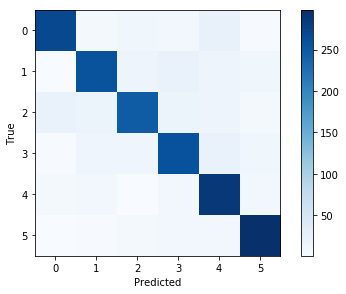

In [23]:
cls_true = b[7756:]
cls_pred = sess.run(tf.argmax(hypothesis, 1), feed_dict=test_feed_dict)
cm = confusion_matrix(y_true=cls_true, y_pred=cls_pred)        

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.tight_layout()
plt.colorbar()
tick_marks = np.arange(6)
plt.xticks(tick_marks, range(6))
plt.yticks(tick_marks, range(6))
plt.xlabel('Predicted')
plt.ylabel('True')

In [24]:
for i in range(6):
    print("[Accuracy: {:>.5f}] {}".format(cm[i][i] / d[i], c[i]))

[Accuracy: 0.83282] 0
[Accuracy: 0.79876] 1
[Accuracy: 0.76543] 2
[Accuracy: 0.80495] 3
[Accuracy: 0.89164] 4
[Accuracy: 0.91975] 5
